In [3]:
from esmvalcore.dataset import Dataset

### double_ITCZ_sea_cycle: meridional structure of the amplitude of the mean seasonal cycle of PR in the eastern Pacific

Computes the meridional root mean square error (RMSE) of eastern Pacific (15°S-15°N) amplitude (standard deviation) of the mean annual cycle (zonal 150-90°W average) precipitation (PR) between model and observations (the time averaging creates a 12 months mean annual cycle time series from which the standard deviation is computed)

## Dataset

Regridding:
model and observations regridded toward a generic 1°x1° grid (using cdms esmf linear method)

Steps (computation):
- detrending (if applicable)
- mean annual cycle computation
- standard deviation computation
- regridding (if applicable)
- zonal average
- RMSE computation

In [4]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='pr',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="18500101/20150101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
"GPCP-SG": 
    Dataset(
    short_name='pr',
    dataset='GPCP-SG',
    mip="Amon",
    project='OBS',
    type='atmos',
    timerange="19790101/20190101",
    tier=2),
}

In [3]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

In [4]:
import iris
from esmvalcore.preprocessor import (
                detrend,
                meridional_statistics,
                zonal_statistics,
                regrid,
                mask_landsea,
                convert_units,
                extract_region,
                climate_statistics )

import numpy as np

In [5]:
def preproc1(cube):
    nino3_latext_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = mask_landsea(cube, mask_out="land")
    cube = convert_units(cube, units="mm/day")
    cube = climate_statistics(cube, operator="mean", period="monthly")
    
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_latext_region)
    cube.coord('month_number').guess_bounds()
    cube = cube.collapsed('month_number', iris.analysis.STD_DEV)
    return cube

def preproc2(cube):
    nino3_latext_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = convert_units(cube, units="mm/day")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="monthly")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_latext_region)
    cube.coord('month_number').guess_bounds()
    cube = cube.collapsed('month_number', iris.analysis.STD_DEV)
    cube = zonal_statistics(cube, 'mean')
    
    return cube

# rmse calc from obs
def rmse(obs_cube, model_cube):
    return np.sqrt(np.mean((obs_cube.data - model_cube.data) ** 2))

In [6]:
model_datasets_prep1 = {name: preproc1(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep1 = {name: preproc1(dataset) for name, dataset in obs_datasets.items()}

model_datasets_prep2 = {name: preproc2(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: preproc2(dataset) for name, dataset in obs_datasets.items()}

## Diagnostics Level 1

Text(0.5, 0, 'Latitude')

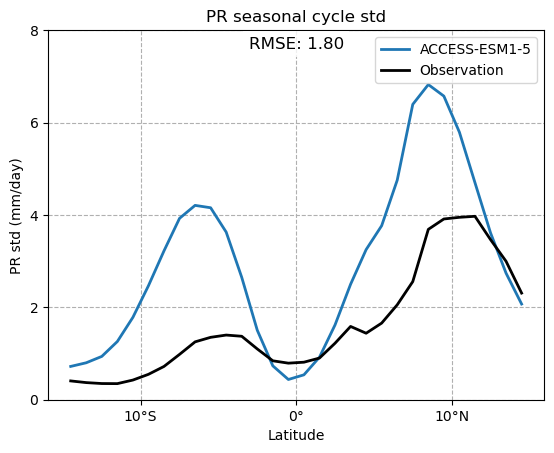

In [7]:
import iris.quickplot as qplt
import matplotlib.pyplot as plt

#plot 1
def format_latitude(x):
    if x < 0:
        return f'{abs(x)}°S'
    elif x > 0:
        return f'{x}°N'
    else:
        return '0°'

obs_data = obs_datasets_prep2["GPCP-SG"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]
error = rmse(obs_data, model_data)

qplt.plot(model_data, label='ACCESS-ESM1-5', linewidth=2)
qplt.plot(obs_data, color='black', label='Observation', linewidth=2)

plt.text(0.5, 0.95, f'RMSE: {error:.2f}', fontsize=12, ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.legend()
# ax = plt.gca()
plt.grid(linestyle='--')
plt.title('PR seasonal cycle std')

plt.yticks(np.arange(0,9, step=2))
plt.ylabel('PR std (mm/day)')

xt = np.arange(-10,15,step=10)
xlab = [format_latitude(x) for x in xt]
plt.xticks(xt,xlab)
plt.xlabel('Latitude')


Figure 1: Meridional bias in the amplitude of the mean seasonal precipitation cycle (PR) in the eastern Pacific (averaged between 150–90°W). The black curve represents the reference data, while the blue curve represents the model data. The metric shown is the meridional RMSE between the model and reference curves.

## Diagnostics level 2

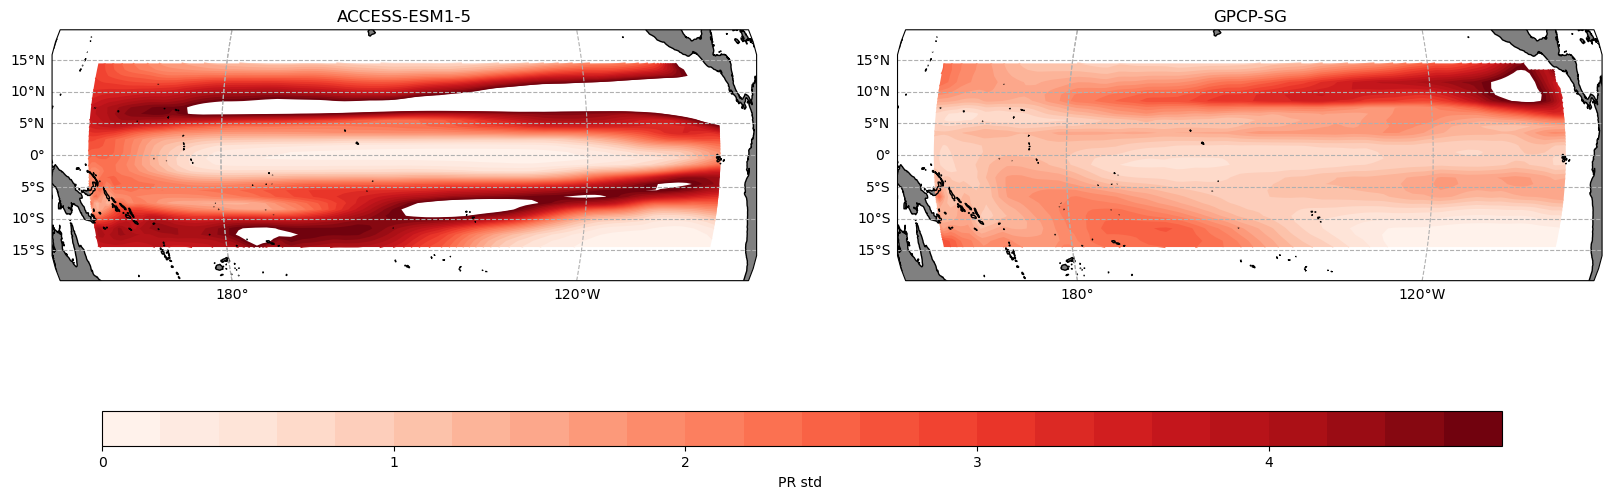

In [8]:
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 7))
proj = ccrs.Orthographic(central_longitude=210.0)
i =121
process = {**model_datasets_prep1, **obs_datasets_prep1}


for label, cube in process.items():
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(0,5,0.2), cmap='Reds')

    ax1.set_extent([130, 290, -20, 20], crs=ccrs.PlateCarree())
    ax1.set_title(label)

    # Add gridlines for latitude and longitude
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False

    i+=1


# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(0,6,1))
cbar.set_label('PR std ')

Figure 2: Bias in the amplitude of the mean seasonal cycle of precipitation (PR) in the equatorial Pacific. The left map shows the reference data, while the right map displays the model data.

# Diagnostic level 3

The third level shows the meridional structure of the mean seasonal cycle in a Hovmöller diagram

In [10]:
def preproc3(cube):
    nino3_latext_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = convert_units(cube, units="mm/day")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="monthly")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_latext_region)
    cube = zonal_statistics(cube, operator='mean')
    
    return cube

model_datasets_prep3 = {name: preproc3(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep3 = {name: preproc3(dataset) for name, dataset in obs_datasets.items()}
process = {**model_datasets_prep3, **obs_datasets_prep3}

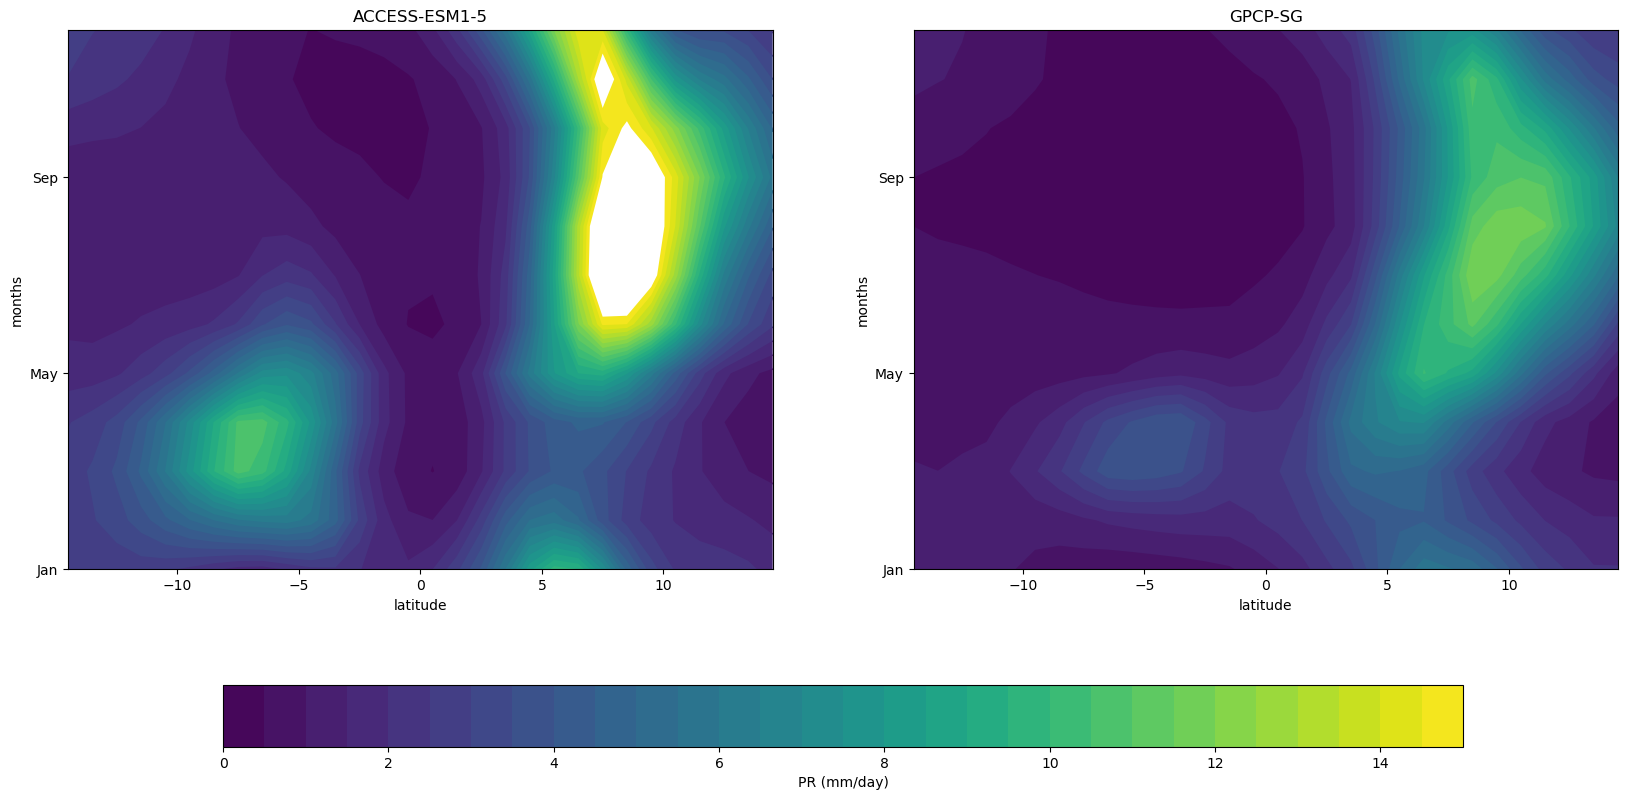

In [15]:
fig = plt.figure(figsize=(20, 10))
i=121

# Define tick positions and labels for the y-axis (months)
month_ticks = np.arange(1, 13, 4)
month_labels =['Jan', 'May', 'Sep'] 
# ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                # 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

axls =[]
for label, cube in process.items():
    
    ax1 = plt.subplot(i)
    cf1 = iplt.contourf(cube,coords=['latitude','month_number'],levels=np.arange(0,15.5,0.5),cmap="viridis")
    ax1.set_ylim(1, 12)
    ax1.set_yticks(ticks=month_ticks, labels=month_labels)
    ax1.set_title(label)
    ax1.set_ylabel("months")
    ax1.set_xlabel("latitude")
    axls.append(ax1)
    i+=1

# Add a single colorbar at the bottom
cbar = fig.colorbar(cf1, ax=axls, orientation='horizontal',shrink=0.8, extend='both')
cbar.set_label('PR (mm/day)')

Figure 3: Meridional structure of the mean seasonal cycle of precipitation (PR) in the eastern Pacific (averaged between 150–90°W). The left map represents the reference data, while the right map shows the model data.